# Lab 2
👨‍🎓 Students:
- Marwan MASHRA
- Nikita KISELOV

In [2]:
!conda install PyWavelets -y

'conda' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [3]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy import fftpack, ndimage
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import pywt

import cv2

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from nt_toolbox.general import *
from nt_toolbox.signal import *

## Read Image

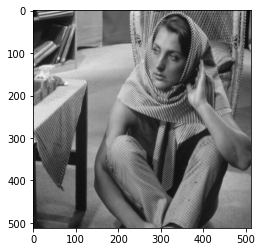

In [5]:
img_orig = cv2.imread('img/barbara.jpg', cv2.IMREAD_GRAYSCALE)
img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min())

# read barbara.jpg image and plot it
plt.imshow(img_orig, cmap='gray')
plt.show()

## Simulate Noisy Image

Here we add noise to the image with various SNR levels. First, we know that for Gaussian noise, the SNR can be computed as following:
$$
\text{SNR} = 10*\log_{10}(\frac{\sigma_{x}^2}{\sigma_{n}^2})
$$
Such that $\sigma_{x}^2$ is the variance of the image, and $\sigma_{n}^2$ is the variance of the Gaussian noise. 

Therefore, we can calculate the standard deviation $\sigma_{n}$ of the noise  as following:
$$
\sigma_{n} = \sqrt{\frac{\sigma_{x}^2}{10^{\text{SNR}/10}}}
$$

Now, we can generate the Gaussian noise by sampling $$\text{noise} \sim \ N(0,\sigma_{n})$$ and add it to the image:
$$
\text{Noisy image} = \text{image} + \text{noise}
$$

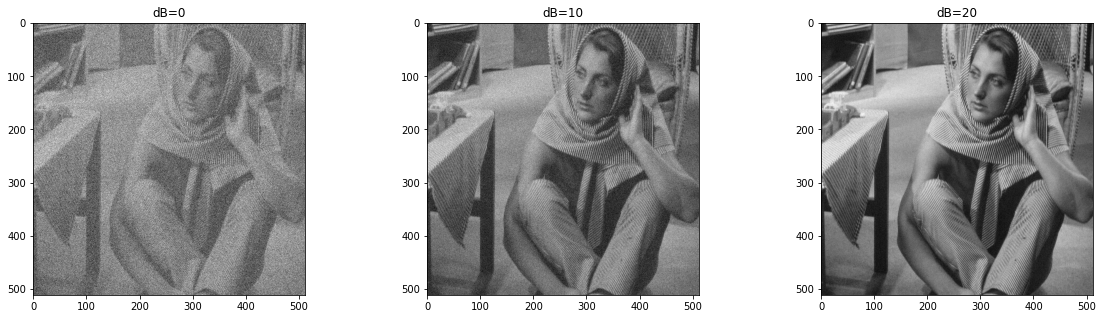

In [6]:
SNR_LIST = [0, 10,20]
noisy_images = {}
# create subplots for each SNR
fig, axs = plt.subplots(1, len(SNR_LIST), figsize=(20, 5))
for i, SNR in enumerate(SNR_LIST):
    # calculate noise variance
    img_var = np.var(img_orig)
    noise_var = img_var/10**(SNR/10)
    noise_std = np.sqrt(noise_var)
    # add noise to image
    noise = np.random.normal(0, noise_std, img_orig.shape)
    noisy_img = img_orig + noise
    noisy_images[SNR] = noisy_img
    # plot noisy image
    axs[i].imshow(noisy_img, cmap='gray')
    axs[i].set_title(f"dB={SNR}")

plt.show()

In [7]:
img = noisy_images[0]

## Orthogonal wavelet transform

### using numerical tour

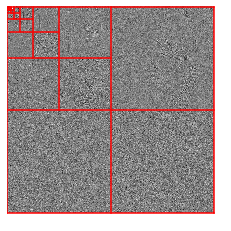

In [8]:
# using numerical tour functions
w_filt = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
w_filt = w_filt/np.linalg.norm(w_filt)
recur_min_depth = 2 # minimum depth of the recursive wavelet transform
img_transformed_nt = perform_wavortho_transf(img, recur_min_depth,+1,w_filt)
plot_wavelet(img_transformed_nt,recur_min_depth);

### using PyWavelets 

PyWavelets returns the wavelet decomposition as coefficients. For 2D single level Discrete Wavelet Transform, that would be :<br>
<pre>
                            -------------------
                            |        |        |
                            | cA(LL) | cH(LH) |
                            |        |        |
(cA, (cH, cV, cD))  <--->   -------------------
                            |        |        |
                            | cV(HL) | cD(HH) |
                            |        |        |
                            -------------------
</pre>

Then for Multilevel (with $n$ level), that would generalize to :<br>
<pre>
[cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)]
</pre>

Therefore, we need to transform those coefficients to another format to be plotted with **plot_wavelet** from Numerical tour

In [9]:
def coeffs_to_img(list_coeffs):
    """converts the coeffs of the wavelet transform to a format that can be plotted with plot_wavelet

    Args:
        list_coeffs (array): coeffs returned by the wavedec2 function of PyWavelets

    Returns:
        array: a format that can be plotted plot_wavelet
    """
    coeffs = list_coeffs[-1]
    if type(coeffs) is not tuple:  # or type(coeffs) is not tuple
        return coeffs
    cH, cV, cD = coeffs
    length = cH.shape[0]
    img = np.zeros((length*2, length*2))
    img[:length, :length] = coeffs_to_img(list_coeffs[:-1])
    img[length:, :length] = cH[:length,:length]
    img[:length, length:] = cV[:length,:length]
    img[length:, length:] = cD[:length,:length]
    return img

Note that this function can only convert orthogonal Wavelets with Filters length of 2. Therefore, we choose here **db1**

In [10]:
# using PyWavelets
wavelet = pywt.Wavelet('db1')
print(wavelet)
assert wavelet.orthogonal and wavelet.rec_len==2   # necessary for the function ton convert via the function coeffs_to_img

Wavelet db1
  Family name:    Daubechies
  Short name:     db
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


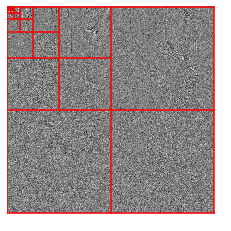

In [11]:
recur_min_depth = wavelet.rec_len
level = int(np.log2(img.shape[1])) - 1 # max level used in the numerical tour
coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
img_transformed_pywt = coeffs_to_img(coeffs)
plot_wavelet(img_transformed_pywt,recur_min_depth);

## Wavelet Denoising with Hard Thresholding

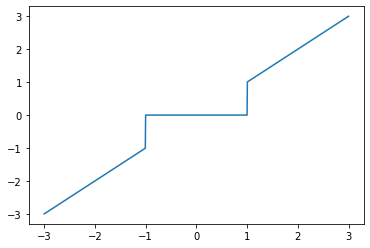

In [12]:
def thresh_hard(u, t):
    return u*(np.abs(u)>t)

alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_hard(alpha,1));

In [13]:
# threshold coefficient
tresh_coef = 0.5

### with numerical tours

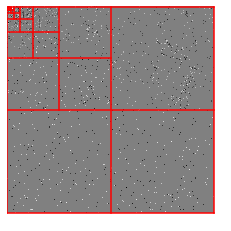

In [14]:
# threshold wavelet image transformation
img_transformed_nt_tr = thresh_hard(img_transformed_nt,tresh_coef)
plot_wavelet(img_transformed_nt_tr,recur_min_depth);


### with PyWavelets

Thresholding the coefficients of the wavelet transform.

In [15]:
def coeffs_thresh(coeffs, thresh, thresh_function):
    """apply a threshold on the coefficients of the wavelet transform

    Args:
        coeffs (_type_): the coefficients returned by pywt.wavedec2
        thresh (int): the threshold
        thresh_function (_type_): the thresholding function (hard, soft...etc). It should take two arguments (element, threshold)

    Returns:
        array: the thresholded coefficients
    """
    u = coeffs.copy()
    for i in range(len(u)):
        if type(u[i]) is not tuple:
            u[i] = thresh_function(u[i], thresh)
        else:
            cH, cV, cD = u[i]
            cH2 = thresh_function(cH, thresh)
            cV2 = thresh_function(cV, thresh)
            cD2 = thresh_function(cD, thresh)
            u[i] = (cH2, cV2, cD2)
    return u

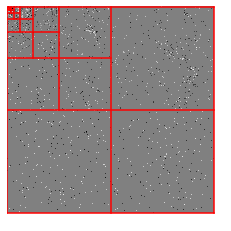

In [16]:
coeffs_tr = coeffs_thresh(coeffs, tresh_coef, thresh_function=thresh_hard)
img_transformed_pywt_tr = coeffs_to_img(coeffs_tr)
plot_wavelet(img_transformed_pywt_tr,recur_min_depth);

Note that we can't really compare those results with the ones we got previously using numerical tour implementation, because they're using **db2**, which we can't plot with their function plot_wavelet. So here we'll do the same but with **db2** to make both results comparable.

In [17]:
# wavelet transform with db2 then hard thresholding
wavelet = pywt.Wavelet('db2')
coeffs = pywt.wavedec2(img, wavelet=wavelet)
coeffs_tr = coeffs_thresh(coeffs, tresh_coef, thresh_function=thresh_hard)

print("Compare coefficients")
print(wavelet.dec_hi)
print(w_filt)

Compare coefficients
[-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]
[ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]


### Show the denoised image

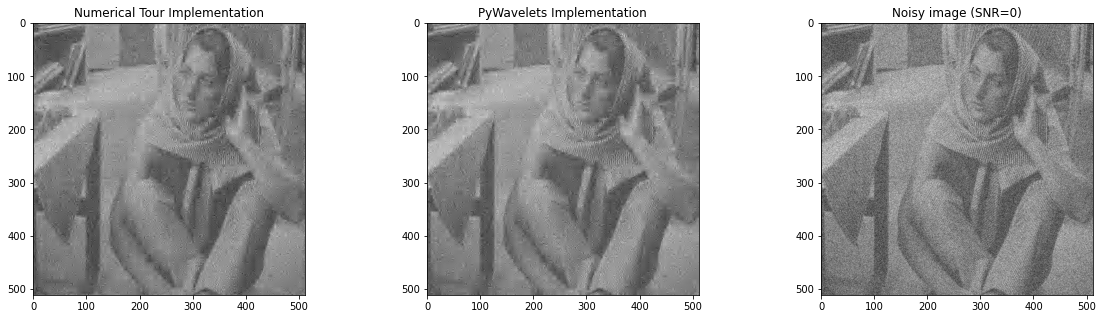

In [18]:
# Inverse wavelet transform to get the denoised image
img_denoised_nt = perform_wavortho_transf(img_transformed_nt_tr,recur_min_depth,-1,w_filt)
img_denoised_pywt = pywt.waverec2(coeffs_tr, wavelet=wavelet)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].imshow(img_denoised_nt, cmap='gray')
axs[0].set_title(f"Numerical Tour Implementation")

axs[1].imshow(img_denoised_pywt, cmap='gray')
axs[1].set_title(f"PyWavelets Implementation")

axs[2].imshow(img, cmap='gray')
axs[2].set_title(f"Noisy image (SNR=0)")

plt.show()

### Let's test several thresholds

In [19]:
def denoise_thresh_hard(img, threshold, wavelet="db2", level=None):
    """Denoises the image using Hard thresholding on the multilevel discrete Wavelet transform from PyWavelets

    Args:
        img (array): the noisy image
        threshold (int): the hard threshold
        wavelet (str, optional): the wavelet to use. Defaults to "db2".

    Returns:
        array: the denoised image
    """
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    coeffs_tr = coeffs_thresh(coeffs, threshold, thresh_function=thresh_hard)
    img_denoised = pywt.waverec2(coeffs_tr, wavelet=wavelet)
    return img_denoised

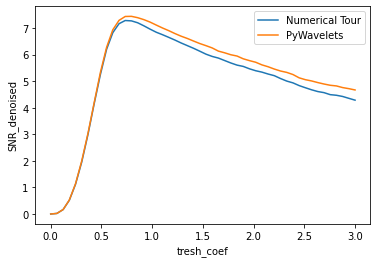

In [20]:
# list of threshold coefficients
tresh_coef_list = np.linspace(0, 3, 50)
snr_list_nt = []
snr_list_pywt = []
img = noisy_images[SNR_LIST[0]] # get image with SNR=0

for tresh_coef in tresh_coef_list:

    # denoise with numerical tour
    img_transformed = perform_wavortho_transf(img, recur_min_depth,+1,w_filt)
    img_transformed_tr = thresh_hard(img_transformed,tresh_coef)
    img_denoised = perform_wavortho_transf(img_transformed_tr,recur_min_depth,-1,w_filt)

    # calculate the snr
    SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
    snr_list_nt.append(SNR_denoised)

    # denoise with PyWavelets
    img_denoised = denoise_thresh_hard(img, tresh_coef)

    # calculate the snr
    SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
    snr_list_pywt.append(SNR_denoised)    
    
# plot SNR vs. threshold coefficient for both implementation
plt.plot(tresh_coef_list, snr_list_nt, label="Numerical Tour")
plt.plot(tresh_coef_list, snr_list_pywt, label="PyWavelets")
plt.legend(loc="upper right")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()

We see that both implementations give similar results, and deduce that we implemented it correctly using PyWavelets.

### Trying other Wavelets

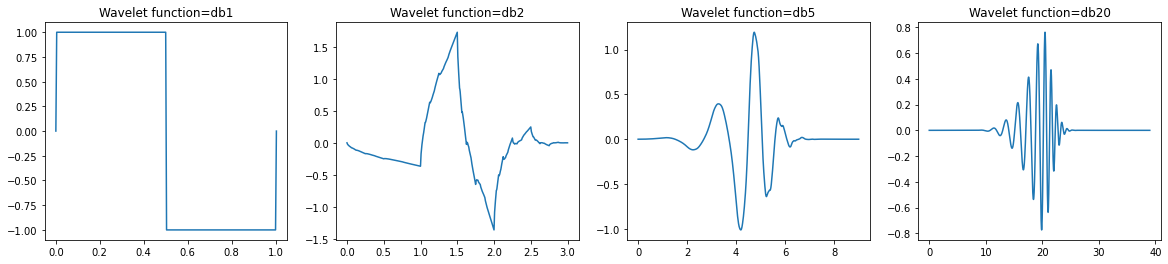

In [21]:
wavelets = ["db1","db2","db5","db20"]
fig, axs = plt.subplots(1, len(wavelets), figsize=(20, 4))
for i, w in enumerate(wavelets):
    wavelet = pywt.Wavelet(w)
    [phi, psi, x] = wavelet.wavefun()
    axs[i].plot(x,psi)
    axs[i].set_title(f"Wavelet function={w}")
plt.show()


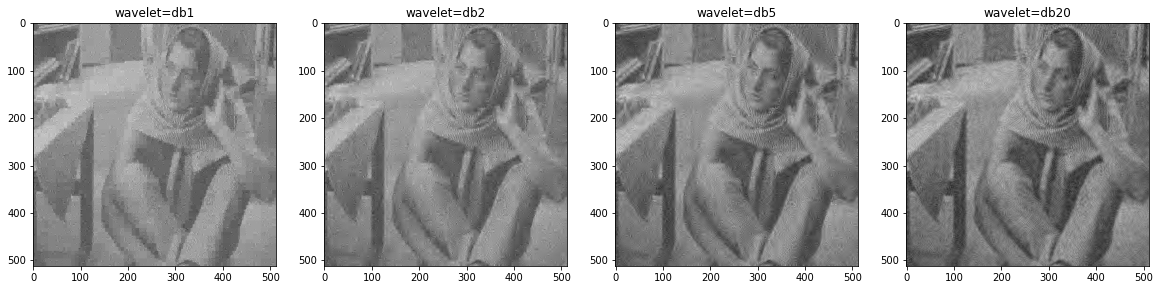

In [22]:
img = noisy_images[0]
fig, axs = plt.subplots(1, len(wavelets), figsize=(20, 5))
for i, wavelet in enumerate(wavelets):
    img_denoised = denoise_thresh_hard(img, 0.5, wavelet=wavelet)
    # plot noisy image
    axs[i].imshow(img_denoised, cmap='gray')
    axs[i].set_title(f"wavelet={wavelet}")
plt.show()

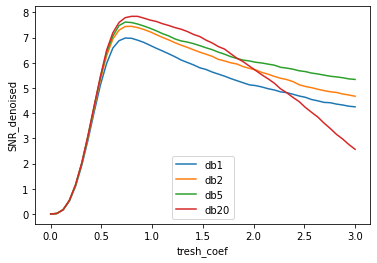

In [23]:
# list of threshold coefficients
tresh_coef_list = np.linspace(0, 3, 50)

img = noisy_images[SNR_LIST[0]] # get image with SNR=0
snr_dict_hard = {wavelet:[] for wavelet in wavelets}
for wavelet in snr_dict_hard:
    for tresh_coef in tresh_coef_list:
        # perform wavelet transformation and denoising
        img_denoised = denoise_thresh_hard(img, tresh_coef, wavelet=wavelet)
        SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
        snr_dict_hard[wavelet].append(SNR_denoised)    
    plt.plot(tresh_coef_list, snr_dict_hard[wavelet], label=wavelet)
    
# plot SNR vs. threshold coefficient
plt.legend(loc="lower center")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()

We notice that :
* All wavelets (beside db1) have quite similar SNR peak and could be used. We decide to use db2 for the following section because it's the one that is most commonly used for images. 
* The best hard threshold is almost the same no matter the wavelet used. 

In [32]:
best_hard_thresh = tresh_coef_list[np.array(snr_dict_hard['db2']).argmax()]
print(f"Best hard threshold for db2 is {best_hard_thresh:.3f}")

Best hard threshold for db2 is 0.796


### Let's try different levels

We use the best hard threshold obtained and compare different decomposition levels

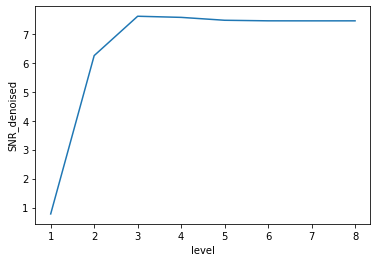

In [55]:
# list of threshold coefficients
img = noisy_images[SNR_LIST[0]] # get image with SNR=0
max_levels = int(np.log2(img.shape[0])) - 1
levels_list = list(range(1, max_levels+1))
snr_list_hard_levels = []
tresh_coef = 0.5
for level in levels_list:
    # denoise with PyWavelets
    img_denoised = denoise_thresh_hard(img, best_hard_thresh, level=level)

    # calculate the snr
    SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
    snr_list_hard_levels.append(SNR_denoised)    
    
# plot SNR vs. threshold coefficient for both implementation
plt.plot(levels_list, snr_list_hard_levels)
plt.xlabel("level")
plt.ylabel("SNR_denoised")
plt.show()

In [57]:
best_hard_level= levels_list[np.array(snr_list_hard_levels).argmax()]
print(f"Best level for best hard threshold {best_hard_level}")

Best level for best hard threshold 3


We see that we can obtain the highest SNR for decomposition levels 3 and higher. However, the difference between level 3 and the other higher levels is quite small.

## Soft threshold

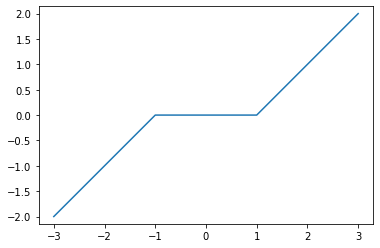

In [26]:
def thresh_soft(u, t):
    return np.maximum(1-t/abs(u), 0)*u

alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_soft(alpha,1))
plt.axis('equal');

In [41]:
def denoise_thresh_soft(img, tresh_coef, wavelet="db2", level=None):
    """Denoises the image using soft thresholding on the multilevel discrete Wavelet transform from PyWavelets

    Args:
        img (array): the noisy image
        threshold (int): the soft threshold
        wavelet (str, optional): the wavelet to use. Defaults to "db2".

    Returns:
        array: the denoised image
    """
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    coeffs_tr = coeffs_thresh(coeffs, tresh_coef, thresh_function=thresh_soft)
    img_denoised = pywt.waverec2(coeffs_tr, wavelet=wavelet)
    return img_denoised

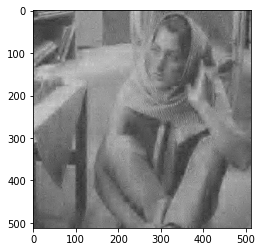

In [28]:
tresh_coef = 0.3
img = noisy_images[SNR_LIST[0]] 
img_denoised = denoise_thresh_soft(img, tresh_coef)
plt.imshow(img_denoised, cmap='gray');

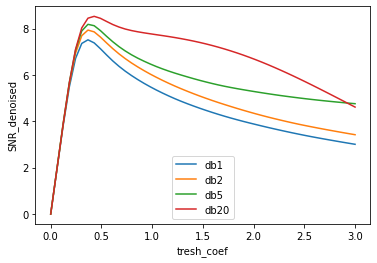

In [29]:
# list of threshold coefficients
tresh_coef_list = np.linspace(0, 3, 50)

img = noisy_images[SNR_LIST[0]] # get image with SNR=0
snr_dict_soft = {wavelet:[] for wavelet in wavelets}
for wavelet in snr_dict_soft:
    for tresh_coef in tresh_coef_list:
        # perform wavelet transformation and denoising
        img_denoised = denoise_thresh_soft(img, tresh_coef, wavelet=wavelet)
        SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
        snr_dict_soft[wavelet].append(SNR_denoised)    
    plt.plot(tresh_coef_list, snr_dict_soft[wavelet], label=wavelet)
    
# plot SNR vs. threshold coefficient
plt.legend(loc="lower center")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()

We notice that, same as for the hard threshold, the best soft threshold is almost the same no matter the wavelet used. 

In [39]:
best_soft_thresh = tresh_coef_list[np.array(snr_dict_soft['db20']).argmax()]
print(f"Best soft threshold for db2 is {best_soft_thresh:.3f}")

Best soft threshold for db2 is 0.429


### Let's try different levels

We use the best soft threshold obtained and compare different decomposition levels

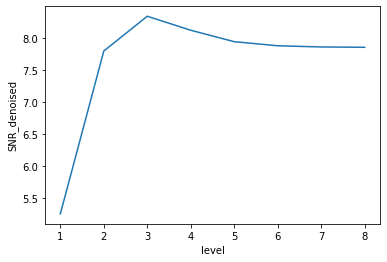

In [53]:
# list of threshold coefficients
img = noisy_images[SNR_LIST[0]] # get image with SNR=0
max_levels = int(np.log2(img.shape[0])) - 1
levels_list = list(range(1, max_levels+1))
snr_list_soft_levels = []

for level in levels_list:
    # denoise with PyWavelets
    img_denoised = denoise_thresh_soft(img, best_soft_thresh, level=level)

    # calculate the snr
    SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
    snr_list_soft_levels.append(SNR_denoised)    
    
# plot SNR vs. threshold coefficient for both implementation
plt.plot(levels_list, snr_list_soft_levels)
plt.xlabel("level")
plt.ylabel("SNR_denoised")
plt.show()

In [58]:
best_soft_level= levels_list[np.array(snr_list_soft_levels).argmax()]
print(f"Best level for best hard threshold {best_soft_level}")

Best level for best hard threshold 3


We notice that, similar to hard threshold, we get the highest SNR for decomposition levels 3. However, here the difference between level 3 and the other higher levels starts to be more significant.

### Let's Comapare Hard and Soft Threshold

We compare the best hard and soft threshold at best levels

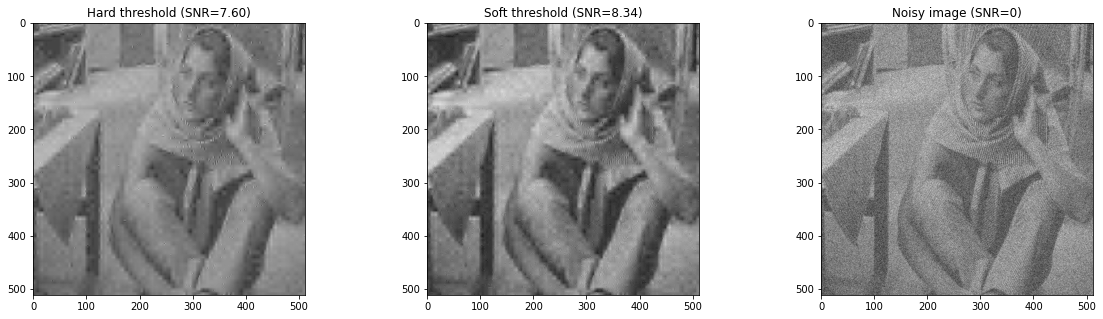

In [66]:

img = noisy_images[SNR_LIST[0]] # get image with SNR=0
img_denoised_hard = denoise_thresh_hard(img, best_hard_thresh, level=best_hard_level)
SNR_denoised_hard = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised_hard))
img_denoised_soft = denoise_thresh_soft(img, best_soft_thresh, level=best_soft_level)
SNR_denoised_soft = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised_soft))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].imshow(img_denoised_hard, cmap='gray')
axs[0].set_title(f"Hard threshold (SNR={SNR_denoised_hard:.2f})")

axs[1].imshow(img_denoised_soft, cmap='gray')
axs[1].set_title(f"Soft threshold (SNR={SNR_denoised_soft:.2f})")

axs[2].imshow(img, cmap='gray')
axs[2].set_title(f"Noisy image (SNR=0)")

plt.show()

We also note that, for the eye, taking the highest SNR doesn't necessarily give the best denoised image. Maximizing for the SNR isn't necessarily the optimal goal and doesn't give the most visually pleasing results.

## Translation Invariant Denoising

Since orthogonal wavelet transform is translation invariant, we can use it to denoise an image by averaging the coefficients of the wavelet transform of the image and its translation. To translate the image, we rotate the image around the center. This is done by the circshift function in the Numerical tour toolbox.

In [ ]:
# Number of translations along the x and y axis
m = 4

In [ ]:
# Generate this shifts
[dY,dX] = np.meshgrid(np.arange(0,m),np.arange(0,m))
delta = np.concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

w_filt = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
w_filt = w_filt/np.linalg.norm(w_filt)

In [ ]:
# Define a function to shift and perform wavelet denoising
def invariant_denoising(img, recur_min_depth, w_filt, t_coef, m):
    fTI = np.zeros([img.shape[0], img.shape[1]])

    for i in np.arange(0,m*m):
        fS = circshift(img,delta[i,:])
        a = perform_wavortho_transf(fS,recur_min_depth,+1,w_filt)
        aT = thresh_hard(a,t_coef)
        fS = perform_wavortho_transf(aT,recur_min_depth,-1,w_filt)
        fS = circshift(fS,-delta[i,:])
        fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS
        
    return fTI

In [ ]:
SNR_LIST

[0, 10, 20]

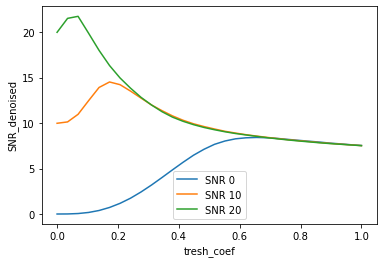

In [ ]:
# list of threshold coefficients
tresh_coef_list = np.linspace(0, 1, 30)

noise_img_dict = {img:[] for img in noisy_images}
for SNR in SNR_LIST:
    img = noisy_images[SNR]
    for tresh_coef in tresh_coef_list:
        # perform wavelet transformation and denoising
        img_denoised = invariant_denoising(img, recur_min_depth, w_filt, tresh_coef, m)
        SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
        noise_img_dict[SNR].append(SNR_denoised)    
    plt.plot(tresh_coef_list, noise_img_dict[SNR], label=f"SNR {SNR}")
    
# plot SNR vs. threshold coefficient
plt.legend(loc="lower center")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()

We can see that threshold is very different for pictures of different SNR. Also, as bigger initial SNR is, the lower coefficients we needed. 

In [ ]:
print("Best coef. SNR=0: ", tresh_coef_list[np.array(noise_img_dict[SNR_LIST[0]]).argmax()])
print("Best coef. SNR=10: ", tresh_coef_list[np.array(noise_img_dict[SNR_LIST[1]]).argmax()])
print("Best coef. SNR=20: ", tresh_coef_list[np.array(noise_img_dict[SNR_LIST[2]]).argmax()])

Best coef. SNR=0:  0.6551724137931034
Best coef. SNR=10:  0.1724137931034483
Best coef. SNR=20:  0.06896551724137931


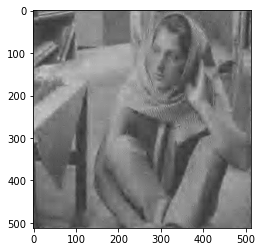

In [ ]:
img = noisy_images[SNR_LIST[0]] # get image with SNR=0
img_denoised = invariant_denoising(img, recur_min_depth, w_filt, tresh_coef_list[np.array(noise_img_dict[SNR_LIST[0]]).argmax()], m)
plt.imshow(img_denoised, cmap='gray')
plt.show()

However visually, for human perception, we can see that the denoised image is better for lower than the best SNR.

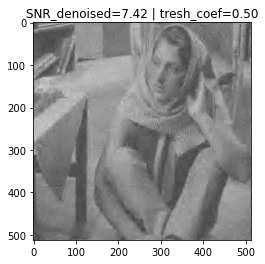

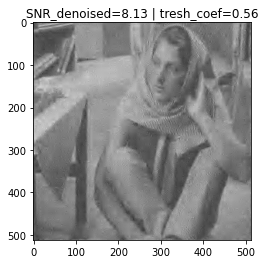

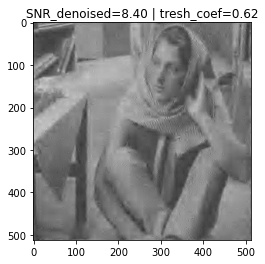

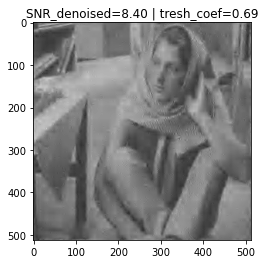

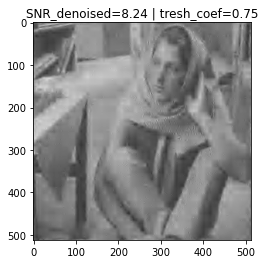

In [ ]:
tresh_coef_list = np.linspace(0.5, 0.75, 5)
img = noisy_images[SNR_LIST[0]] # get image with SNR=0
for tresh_coef in tresh_coef_list:

    img_denoised = invariant_denoising(img, recur_min_depth, w_filt, tresh_coef, m)
    
    # calculate SNR of the denoised image
    SNR_denoised = 10*np.log10(np.var(img_orig)/np.var(img_orig - img_denoised))
    
    # plot image
    plt.imshow(img_denoised, cmap='gray')
    plt.title(f"SNR_denoised={SNR_denoised:.2f} | tresh_coef={tresh_coef:.2f}")
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf0008da-68c3-4ba8-b216-38902f450eed' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>